# Import and Clean Data

In [9]:
#Import our dependencies.
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import codecs
import psycopg2
from config import password
import seaborn as sns
%matplotlib inline
from sklearn import metrics
from sklearn.decomposition import PCA
import hvplot.pandas

In [10]:
# Connection parameters
param_dic = {
    "host"      : "tourism.cwo7jzoryi7x.us-east-2.rds.amazonaws.com",
    "database"  : "postgres",
    "user"      : "postgres",
    "password"  : password
}
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [11]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tuples
    tuples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tuples, columns=column_names)
    return df

In [12]:
# Connect to the database
conn = connect(param_dic)
column_names=['birth_rate','country', 'gdp', 'health_exp_percent_gdp', 'health_exp_per_capita', 'infant_mortality_rate', 'internet_usage','life_expectancy_female', 'life_expectancy_male', 'mobile_phone_usage', 'no_of_records', 'population_0_to_14', 'population_15_to_64', 'population_65_plus', 'population_total', 'population_urban', 'region', 'tourism_inbound', 'tourism_outbound', 'year', 'header', 'personal', 'business', 'total', 'africa', 'americas', 'east_asia_and_pacific', 'europe', 'middle_east', 'south_asia', 'others']
# Execute the "SELECT *" query
tourism_df = postgresql_to_dataframe(conn, "select * from merged_data", column_names)
tourism_df.head()

Connecting to the PostgreSQL database...
Connection successful


birth_rate              country           gdp  health_exp_percent_gdp  \
0       0.012              georgia  3.057453e+09                   0.069   
1       0.013       macedonia, fyr  3.586884e+09                   0.087   
2       0.013               france  1.326330e+12                   0.101   
3         NaN  st. kitts and nevis  4.165670e+08                   0.043   
4       0.040    equatorial guinea  1.045999e+09                   0.024   

   health_exp_per_capita  infant_mortality_rate  internet_usage  \
0                   45.0                  0.031             0.0   
1                  153.0                  0.014             0.0   
2                 2209.0                  0.004             0.1   
3                  392.0                  0.014             0.1   
4                   57.0                  0.099             0.0   

   life_expectancy_female  life_expectancy_male  mobile_phone_usage  ...  \
0                    75.0                  68.0                 0.0  ...   
1                    76.0                  71.0                 0.1  ...   
2                    83.0                  75.0                 0.5  ...   
3                     NaN                   NaN                 0.0  ...   
4                    49.0                  46.0                 0.0  ...   

   personal  business  total  africa  americas  east_asia_and_pacific europe  \
0       NaN       NaN    NaN     NaN       NaN                    NaN    NaN   
1       NaN       NaN    NaN     NaN       NaN                    NaN    NaN   
2       NaN       NaN    NaN     NaN       NaN                    NaN    NaN   
3       NaN       NaN    NaN     NaN       NaN                    NaN    NaN   
4       NaN       NaN    NaN     NaN       NaN                    NaN    NaN   

   middle_east  south_asia  others  
0          NaN         NaN     NaN  
1          NaN         NaN     NaN  
2          NaN         NaN     NaN  
3          NaN         NaN     NaN  
4          NaN         NaN     NaN  

[5 rows x 31 columns]

In [13]:
# Dropping the columns with null values
tourism_df = tourism_df.dropna()
# Identifying the dimenions
tourism_df.shape

(1269, 31)

In [14]:
#Create percentage columns for the type of tourism.
tourism_df["personal_percentage"] = tourism_df.apply(lambda row: (row.personal/(row.personal+row.business))*100, axis = 1)
tourism_df["business_percentage"] = tourism_df.apply(lambda row: (row.business/(row.personal+row.business))*100, axis = 1)
tourism_df.head()

birth_rate   country           gdp  health_exp_percent_gdp  \
16       0.019   albania  3.686649e+09                   0.064   
21       0.013   armenia  1.911564e+09                   0.063   
23       0.042   burundi  8.704861e+08                   0.063   
24       0.028  cambodia  3.654032e+09                   0.063   
25       0.011    canada  7.394560e+11                   0.088   

    health_exp_per_capita  infant_mortality_rate  internet_usage  \
16                   70.0                  0.023             0.0   
21                   39.0                  0.027             0.0   
23                    7.0                  0.092             0.0   
24                   19.0                  0.082             0.0   
25                 2090.0                  0.005             0.5   

    life_expectancy_female  life_expectancy_male  mobile_phone_usage  ...  \
16                    77.0                  71.0                 0.0  ...   
21                    75.0                  68.0                 0.0  ...   
23                    49.0                  47.0                 0.0  ...   
24                    65.0                  59.0                 0.0  ...   
25                    82.0                  77.0                 0.3  ...   

      total  africa  americas  east_asia_and_pacific  europe  middle_east  \
16    295.0     0.2      14.0                    2.0   295.0          1.0   
21     45.0     0.0       8.0                    1.0    25.0          2.0   
23     29.0    14.0       2.0                    1.0    12.0          0.0   
24    351.0     0.0      42.0                  152.0    66.0          0.0   
25  19554.0    65.0   15605.0                 1340.0  2499.0         45.0   

   south_asia  others  personal_percentage  business_percentage  
16        0.4     4.0            73.898305            26.101695  
21        9.0     0.0            91.111111             8.888889  
23        0.0     0.0            65.517241            34.482759  
24        3.0     0.0            86.609687            13.390313  
25       74.0     0.0            85.465889            14.534111  

[5 rows x 33 columns]

In [15]:
def tourism_type(x):
    if x >= 85:
        return "Personal"
    else:
        return "Business"

In [16]:
# Defining the output 
tourism_df["higher_tourism"] = tourism_df["personal_percentage"].apply(tourism_type)
tourism_df.head()

birth_rate   country           gdp  health_exp_percent_gdp  \
16       0.019   albania  3.686649e+09                   0.064   
21       0.013   armenia  1.911564e+09                   0.063   
23       0.042   burundi  8.704861e+08                   0.063   
24       0.028  cambodia  3.654032e+09                   0.063   
25       0.011    canada  7.394560e+11                   0.088   

    health_exp_per_capita  infant_mortality_rate  internet_usage  \
16                   70.0                  0.023             0.0   
21                   39.0                  0.027             0.0   
23                    7.0                  0.092             0.0   
24                   19.0                  0.082             0.0   
25                 2090.0                  0.005             0.5   

    life_expectancy_female  life_expectancy_male  mobile_phone_usage  ...  \
16                    77.0                  71.0                 0.0  ...   
21                    75.0                  68.0                 0.0  ...   
23                    49.0                  47.0                 0.0  ...   
24                    65.0                  59.0                 0.0  ...   
25                    82.0                  77.0                 0.3  ...   

    africa  americas  east_asia_and_pacific  europe  middle_east  south_asia  \
16     0.2      14.0                    2.0   295.0          1.0         0.4   
21     0.0       8.0                    1.0    25.0          2.0         9.0   
23    14.0       2.0                    1.0    12.0          0.0         0.0   
24     0.0      42.0                  152.0    66.0          0.0         3.0   
25    65.0   15605.0                 1340.0  2499.0         45.0        74.0   

   others  personal_percentage  business_percentage  higher_tourism  
16    4.0            73.898305            26.101695        Business  
21    0.0            91.111111             8.888889        Personal  
23    0.0            65.517241            34.482759        Business  
24    0.0            86.609687            13.390313        Personal  
25    0.0            85.465889            14.534111        Personal  

[5 rows x 34 columns]

In [17]:
# count unique values ascending
tourism_df['higher_tourism'].value_counts(ascending=True)

Personal    605
Business    664
Name: higher_tourism, dtype: int64

In [18]:
# Listing the columns in the dataframe
tourism_df.columns.to_list()

['birth_rate',
 'country',
 'gdp',
 'health_exp_percent_gdp',
 'health_exp_per_capita',
 'infant_mortality_rate',
 'internet_usage',
 'life_expectancy_female',
 'life_expectancy_male',
 'mobile_phone_usage',
 'no_of_records',
 'population_0_to_14',
 'population_15_to_64',
 'population_65_plus',
 'population_total',
 'population_urban',
 'region',
 'tourism_inbound',
 'tourism_outbound',
 'year',
 'header',
 'personal',
 'business',
 'total',
 'africa',
 'americas',
 'east_asia_and_pacific',
 'europe',
 'middle_east',
 'south_asia',
 'others',
 'personal_percentage',
 'business_percentage',
 'higher_tourism']

# Data Preprocessing

In [19]:
# Data Preprocessing
tourism_df = tourism_df.drop(["region", "header", "country", "year", "total", "no_of_records"], axis=1)

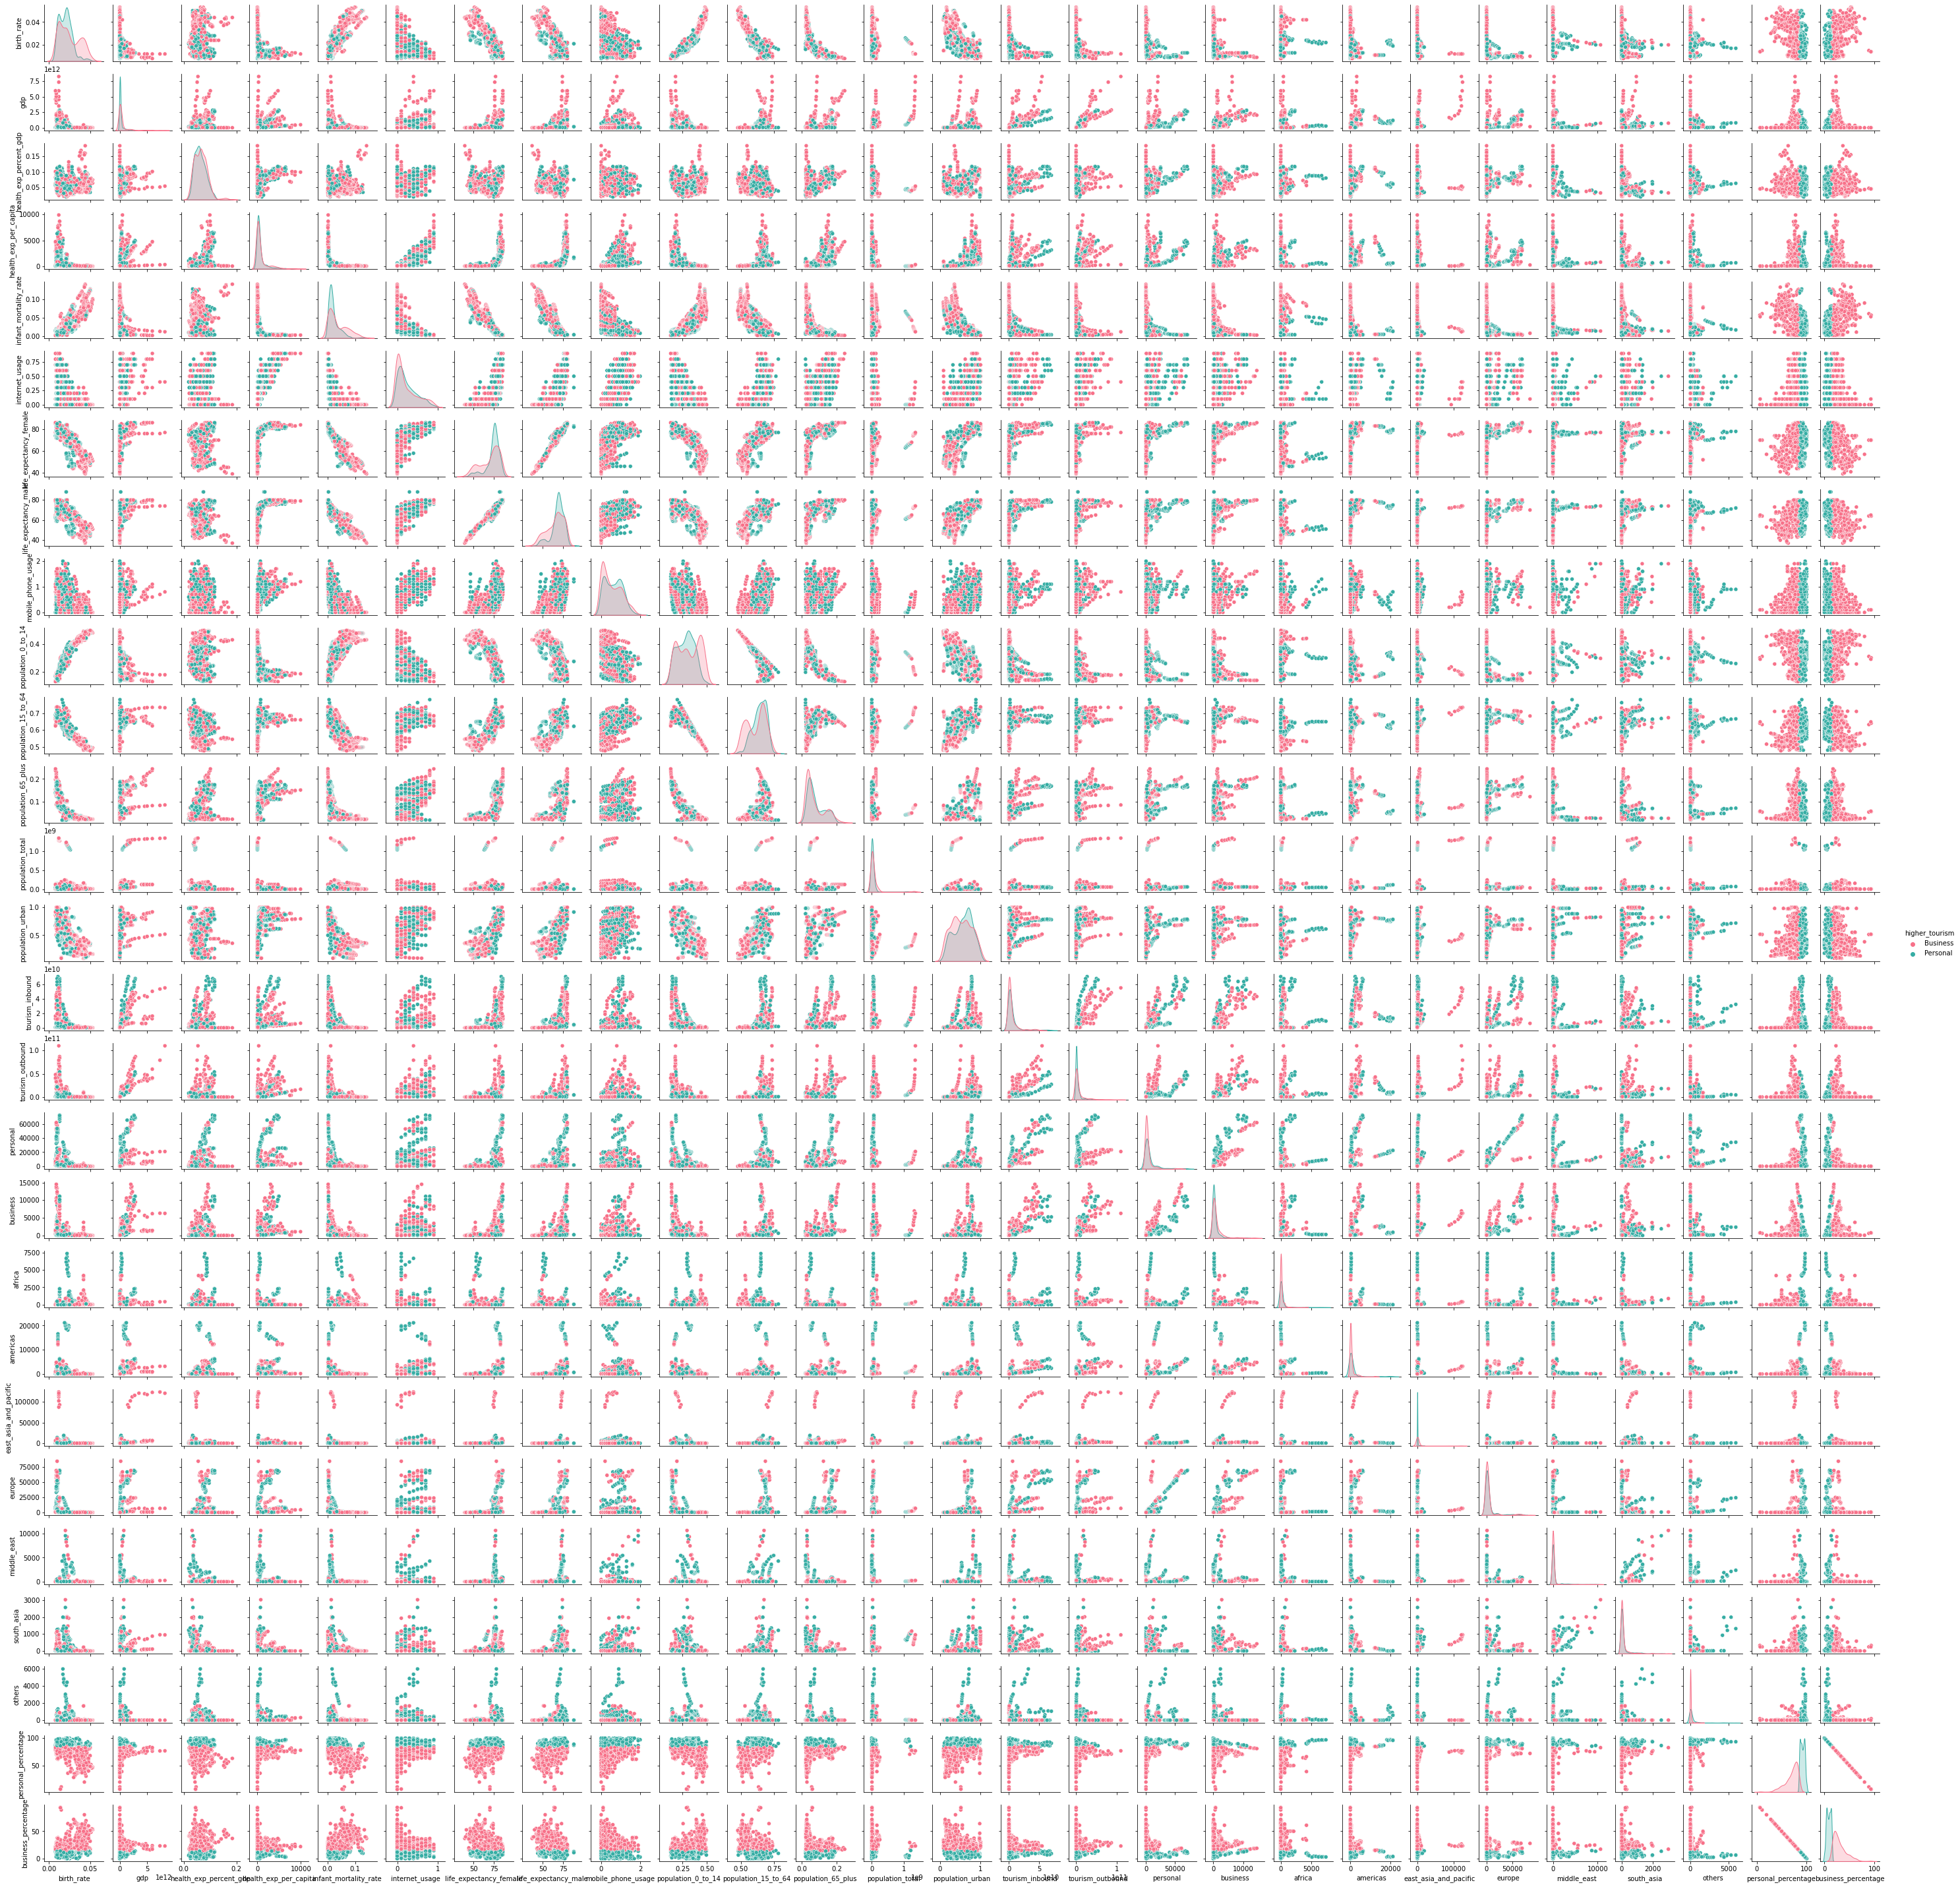

In [112]:
# Creating a pairplot with the hue as ‘higher_tourism’ to analyze the relationship between every variable
sns.pairplot(tourism_df, hue='higher_tourism', palette='husl', height=1.5)

In [20]:
#Seperate the feature X from the target y
y = tourism_df['higher_tourism']
X = tourism_df.drop(columns=['higher_tourism', 'personal_percentage', 'business_percentage'])

# Logistic Regression

Logistic Regression is a supervised learning model that is used for predicting binary outcomes. The dependent variable is categorical in this approach. It is used in statistics and machine learning to understand the relationship between the dependent variable and one or more independent variables by estimating probabilities using a logistic regression equation. This type of analysis can help predict the probability of an event happening. In our case, it is used to predict what type of tourism is more likely in a country. The analysis looks at Personal tourists, Business tourists, number of visitors from various regions (Africa, Americas, East Asia and Pacific, Europe, Middle East), Population of different age groups (65+, 15-64, 0-14), Urban Population, Inbound Tourism, Outbound Tourism (Independant variables). The information from the analysis can be used by the Itinerary Preparation Department to develop appropriate travel packages for various countries.

The dataset (features and target) is split into test and train sets using the train_test_split() function.
Scikit-learn's StandardScaler module is used to standardize numerical data.
A logistic regression model is created. LogisticRegression is imported from the Scikit-learn library, and then the model is instantiated.
The model is then trained with the training data using fit() method.
Predictions are made using predict() method on X_test and the results are assembled into results DataFrame.
The model is then validated with the accuracy score.

Benefits of Logistic Regression

- Logistic regression is much easier to set up and train than other machine learning models.
- When data is linearly separable, it is one of the most eficient algorithms.

Limitaions of Logistic Regression

- On high dimensional datasets, there is a high probability of overstating the accuracy of predictions on the training set and thus the model may not be able to predict accurate results on the test set.
- It is difficult to capture complex relationships.
- Logistic Regression requires moderate or no multicollinearity between independent variables.

Scikit-learn is the machine learning library for the Python. Using train_test_split() from scikit-learn, the dataset is split into subsets: training and testing datasets for evaluation and validation of the Machine Learning model. 

Following is the split of the training and testing dataset.
- Training set - 951 train samples (75%)
- Testing set - 318 test samples (25%)

In [21]:
#Split, train, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2, stratify = y)
X_train.shape

(951, 25)

In [22]:
#Create a StandardScaler instances
scaler = StandardScaler()

#Fit
X_scaler = scaler.fit(X_train)

#Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
#Create a Logistic Regression Model
classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1)

In [24]:
#Fit (train) or model using the training data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [25]:
#Predictions
y_pred = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head()

Prediction    Actual
0   Personal  Business
1   Personal  Personal
2   Business  Personal
3   Personal  Personal
4   Business  Business

In [26]:
#Accuracy score
print(accuracy_score(y_test, y_pred))

0.8490566037735849


In [27]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[136  30]
 [ 18 134]]


In [28]:
# Display classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    Business       0.88      0.82      0.85       166
    Personal       0.82      0.88      0.85       152

    accuracy                           0.85       318
   macro avg       0.85      0.85      0.85       318
weighted avg       0.85      0.85      0.85       318



The model has an accuracy score of 84.90%. This means that 85% of the observations in the testing set are predicted correctly by the model. In addition, confusion matrix is generated to visualize the performance of the model. The table below summarizes the confusion matrix.
To evaluate the model further, classification report is generated for the model to measure the quality of predictions.

- Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives. Our model has a precision score of 0.88 for Business and 0.82 for Personal.
- Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Our model has a precision score of 0.82 for Business and 0.88 for Personal.
- F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. Our model has a high F1 score of 0.85.

# Visualization of the Confusion Matrix using Heatmap


Text(0.5, 257.44, 'Predictions')

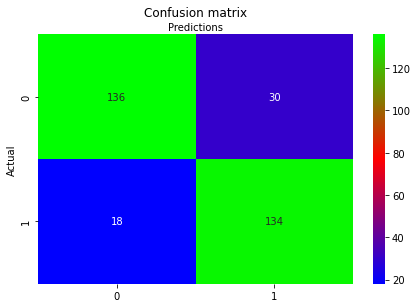

In [29]:
# name  of classes
classes=['Personal', 'Business'] 
# initializing figure and subplot axes.
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# create heatmap
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="brg" ,fmt='g')
ax.xaxis.set_label_position("top")
# adjusting subplot params
plt.tight_layout()
# defining the title , x and y labels
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predictions')

# Linear Regression

Linear Regression is a supervised learning model that is used for finding linear relationship between target (dependent variable) and independent variables. The case of more than one feature is called as multiple linear regression.

The dataset(features and target) is split into test and train sets using the train_test_split() function.
Scikit-learn's StandardScaler module is used to standardize numerical data.
Instance of the linear regression model is created from sklearn.linear_model's LinearRegression class.
Data is analyzed to learn patterns in the training stage.
Predict() method is used to generate predictions on the test dataset (X_test).

Benefits of Linear Regression
- It is a very efficient model and is easy to train.
- Modeling speed is fast and the predictions run fast with large amount of data.

Limitations of Linear Regression
- It is highly affected by outliers.
- It is prone to overfitting if there is not much data.
- Multicollinearity should be removed before performing linear regression.

In [30]:
#Seperate the feature X from the target y
y2 = tourism_df['personal_percentage']
X2 = tourism_df.drop(columns=['higher_tourism', 'personal_percentage', 'business_percentage'])

Following is the split of the training and testing dataset.
- Training set - 951 train samples (75%)
- Testing set - 318 test samples (25%)

In [62]:
#Split, train, and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 2, stratify = y)
X2_train.shape

(951, 25)

In [32]:
#Create a Linear Regression Model
lr = LinearRegression()

In [33]:
#Fit (train) or model using the training data
lr.fit(X2_train, y2_train)

LinearRegression()

In [34]:
#Generate predictions
y2_predictions = lr.predict(X2_test)
y2_predictions

array([ 82.88618896,  85.24349346,  87.37257064,  89.81761854,
        76.52432318,  76.24381234,  59.50918952,  72.45906018,
        62.05246903,  71.21740743,  74.63846023,  53.32441845,
        71.81072396,  82.5676471 ,  95.06741585,  82.89898931,
        82.7576246 ,  80.37982129,  84.88005289,  70.22365784,
        76.52029087,  84.27073222,  89.80220914,  98.44074582,
        88.43749194,  70.57028411,  71.49212671,  83.65003466,
        46.68349707,  55.57217382,  74.20203029,  69.26790523,
        90.3716133 ,  75.31177918,  83.85523944,  75.12530976,
        59.28070081,  81.47371988,  80.30090174,  90.79401496,
        84.09235131,  77.17586002,  79.60403754, 102.15501254,
        97.53306179,  83.5518709 ,  80.16271612,  88.06677025,
        68.84698187,  80.73891094,  80.47363117,  68.02616263,
        55.15506109,  73.2897934 ,  58.32511367,  86.00303881,
        82.74814274,  84.2829333 ,  77.83482448,  79.03636562,
        80.56052954,  83.15175436,  69.9461718 ,  76.81

In [35]:
#Root Mean Square Error (RMSE)
accuracy_regression = print(np.sqrt(metrics.mean_squared_error(y2_test, y2_predictions)))

11.274187837427398


In [36]:
#Actual value and the predicted value
lr_diff = pd.DataFrame({'Actual value': y2_test, 'Predicted value': y2_predictions})
lr_diff.head()

Actual value  Predicted value
16       73.898305        82.886189
726      88.822355        85.243493
1290     85.617718        87.372571
2508     98.804781        89.817619
862      71.297455        76.524323

The model has Root Mean Square Error (RMSE) of 11.27. RMSE is the standard way to measure the error of a model in predicting quantitative data. It shows how far predictions fall from measured true values using Euclidean distance. 

# PCA

In [38]:
#Create a StandardScaler instances
#Fit and scale the data
data_scaled = StandardScaler().fit_transform(X)
print(data_scaled[0:5])

[[-0.3267463  -0.36751738  0.02819184 -0.51441183 -0.24184883 -0.93155592
   0.51658942  0.46663246 -1.26716092  0.04005275  0.03441409 -0.14476888
  -0.27417314 -0.53405143 -0.43571293 -0.40943388 -0.45353534 -0.43609389
  -0.27951185 -0.33040806 -0.14679976 -0.32201297 -0.21069617 -0.3537111
  -0.25654711]
 [-0.88493485 -0.3698252  -0.01592091 -0.53762862 -0.10217143 -0.93155592
   0.32723298  0.14346168 -1.26716092 -0.3927681   0.2395927   0.49353457
  -0.27424963  0.42086912 -0.46869451 -0.43042886 -0.46979733 -0.47500996
  -0.27981662 -0.3327613  -0.14689435 -0.34401532 -0.20951454 -0.32313546
  -0.2647669 ]
 [ 1.81297646 -0.37117873 -0.01592091 -0.56159433  2.1675863  -0.93155592
  -2.13440065 -2.11873379 -1.26716092  1.87954136 -2.28568253 -0.92270122
  -0.25296122 -1.92491396 -0.47351782 -0.43419719 -0.47181859 -0.47181138
  -0.25848255 -0.33511453 -0.14689435 -0.34507469 -0.2118778  -0.35513323
  -0.2647669 ]
 [ 0.51053652 -0.36755978 -0.01592091 -0.55260719  1.81839281 -0.931

In [39]:
#initializa PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=11)
data_pca = pca.fit_transform(data_scaled)

In [40]:
# Create a DataFrame with the principal components.
data_pca_df = pd.DataFrame(data=data_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11"])
data_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.989809 -0.904115  0.206852 -0.665499 -0.822905  0.127997 -0.303524   
1 -0.482725 -1.195902  0.190354 -0.707769 -0.767459 -0.144672  0.015216   
2 -5.214297  2.023466 -1.200125  0.108879  0.321223  0.210435 -0.727318   
3 -3.351433  0.766943 -0.488567 -0.297002 -0.257524  0.171186 -0.549871   
4  4.098462  0.509041 -1.114963 -0.666187  0.098908  3.845418  0.389436   

        PC8       PC9      PC10      PC11  
0 -0.316307  0.910971  0.801813  0.262731  
1 -0.396504  1.444444  0.626185 -0.496152  
2  0.756709 -0.212354 -0.362780 -0.397477  
3  0.310299  0.267080  0.046768 -0.187002  
4 -3.236417  0.584944 -1.487013 -0.755015

In [41]:
#Explained variance
pca.explained_variance_ratio_

array([0.39155952, 0.13870396, 0.0929561 , 0.06738871, 0.05130301,
       0.0435726 , 0.03749001, 0.03339834, 0.02254432, 0.02036132,
       0.01955651])

# Linear Regression after PCA

In [54]:
y3 = data_scaled['personal_percentage']
X3 = data_pca_df

In [55]:
#Split, train, and test
from sklearn.model_selection import train_test_split

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 2, stratify = y)

X3_train.shape

(951, 12)

In [56]:
LReg = LinearRegression()

In [57]:
LReg.fit(X3_train.fillna(X3_train.mean()), y3_train)

LinearRegression()

In [58]:
y3_predic = LReg.predict(X3_test)
y3_predic

array([ 80.42167808,  82.36393008,  80.84201716,  88.13681054,
        82.05788467,  81.7001413 ,  59.70848548,  74.12846553,
        74.43238351,  72.2163032 ,  81.62588016,  61.32875604,
        76.93194946,  84.58872486,  80.24510504,  81.64551586,
        78.95320166,  78.76270241,  83.58313241,  71.6048438 ,
        71.80993648,  87.78929891,  81.09482877,  98.57875266,
        83.72765048,  72.92273238,  73.37392081,  87.01482156,
        57.43042519,  81.50789238,  72.81163396,  75.78178505,
        90.73360177,  73.51467113,  88.63257281,  78.16720378,
        62.97941622,  84.25960452,  80.05020407,  85.78438398,
        85.2313498 ,  82.69851676,  83.07353342,  98.3655289 ,
        94.13466422,  88.99393352,  80.44593347,  84.24861831,
        72.72068449,  73.6296141 ,  89.06815523,  71.13050835,
        62.95455837,  77.68715227,  63.11027486,  86.8896389 ,
        85.33790241,  83.04921819,  80.97571782,  81.54967522,
        79.75758465,  82.4553412 ,  72.31575014,  84.63

In [59]:
from sklearn import metrics
#Root Mean Square Error (RMSE)
accuracy_reg = print(np.sqrt(metrics.mean_squared_error(y2_test, y_predic)))

11.844091194230485
